# Capstone Project - Battle of the Neighborhoods

## Analysis

First, import necessary libraries to complete analysis

In [1]:
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import folium
from folium.plugins import MarkerCluster
import folium.plugins as plugins
print('Libraries imported.')

C:\Users\Robbie\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries imported.


Download dataset from unitedstateszipcode.org

In [2]:
#Obtain Zipcodes (includes Latitude and Longitude)
zipcodes = pd.read_csv(r'C:\Users\\zip_code_database.csv') #csv obtained from online zipcode site, includes all US zipcodes
print(zipcodes.shape)
zipcodes.head()

(42632, 15)


,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


Clean data set by removing columns unnecessary to our analysis
Drop decommissioned, unacceptable_cities, timezone, area_codes, world_region, irs_estimated_population_2015
Remove business and PO Box zip code listings

In [3]:
zipcodes.drop(['decommissioned','unacceptable_cities','timezone','area_codes','world_region','irs_estimated_population_2015'],axis=1,inplace=True)
zipcodes = zipcodes[zipcodes['type']=='STANDARD']
print (zipcodes.shape)
zipcodes.head()

(29983, 9)


,zip,type,primary_city,acceptable_cities,state,county,country,latitude,longitude
2,601,STANDARD,Adjuntas,NaN,PR,Adjuntas Municipio,US,18.16,-66.72
3,602,STANDARD,Aguada,NaN,PR,Aguada Municipio,US,18.38,-67.18
4,603,STANDARD,Aguadilla,Ramey,PR,Aguadilla Municipio,US,18.43,-67.15
7,606,STANDARD,Maricao,NaN,PR,Maricao Municipio,US,18.18,-66.98
8,610,STANDARD,Anasco,NaN,PR,Anasco Municipio,US,18.28,-67.14


In acceptable_cities column, replace NaN with primary_city value

In [4]:
#When 'acceptable city' is NA, replace with primary_city
zipcodes['acceptable_cities'].fillna(zipcodes.primary_city,inplace=True)
zipcodes.head()

,zip,type,primary_city,acceptable_cities,state,county,country,latitude,longitude
2,601,STANDARD,Adjuntas,Adjuntas,PR,Adjuntas Municipio,US,18.16,-66.72
3,602,STANDARD,Aguada,Aguada,PR,Aguada Municipio,US,18.38,-67.18
4,603,STANDARD,Aguadilla,Ramey,PR,Aguadilla Municipio,US,18.43,-67.15
7,606,STANDARD,Maricao,Maricao,PR,Maricao Municipio,US,18.18,-66.98
8,610,STANDARD,Anasco,Anasco,PR,Anasco Municipio,US,18.28,-67.14


Pull Austin, TX for analysis
Note - I explored the csv file to identify Austin city zip codes used below

In [5]:
atxzip=zipcodes[zipcodes['zip'].between(78701,78799)]
print(atxzip.shape)
print('There are {} unique city names in the Austin metro area'.format(len(atxzip['acceptable_cities'].unique())))
atxzip.head()

(47, 9)
There are 6 unique city names in the Austin metro area


,zip,type,primary_city,acceptable_cities,state,county,country,latitude,longitude
34702,78701,STANDARD,Austin,Austin,TX,Travis County,US,30.26,-97.74
34703,78702,STANDARD,Austin,Austin,TX,Travis County,US,30.26,-97.71
34704,78703,STANDARD,Austin,Austin,TX,Travis County,US,30.29,-97.77
34705,78704,STANDARD,Austin,Austin,TX,Travis County,US,30.24,-97.77
34706,78705,STANDARD,Austin,Austin,TX,Travis County,US,30.29,-97.74


Assign numbers to duplicate city names with different zip codes to identify them as unique

In [6]:
atxlist = atxzip['acceptable_cities'].to_list()

atxcities = []
for i, v in enumerate (atxlist):
    totalcount = atxlist.count(v)
    count = atxlist[:i].count(v)
    atxcities.append(v + str(count + 1) if totalcount > 1 else v)

Add this list back into the atxzip dataframe

In [7]:
atxzip['cityname']=atxcities

<ipython-input-7-5c24a494903f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atxzip['cityname']=atxcities


Verify shape and number of unique city names are the same
This is a sanity check to verify the new column generated correctly

In [8]:
print(atxzip.shape)
print('There are {} unique city names in the Austin metro area'.format(len(atxzip['cityname'].unique())))

(47, 10)
There are 47 unique city names in the Austin metro area


Obtain the latitude and longitude coordinates for Austin, TX using the geopy library

In [9]:
address = 'Austin, TX'

geolocator = Nominatim (user_agent='atx_explorer')
location= geolocator.geocode(address)
latatx=location.latitude
longatx= location.longitude

print('The geographical location of Austin is {}, {}.'.format(latatx,longatx))

The geographical location of Austin is 30.2711286, -97.7436995.


Define Foursquare credentials and version

In [10]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = ''
LIMIT = 100

Explore first neighborhood in the atxzip dataframe

In [11]:
atxzip.loc[34702,'cityname']

'Austin1'

Obtain the neighborhood's latitude and longitude coordinates

In [12]:
neighborhood_lat=atxzip.loc[34702,'latitude']
neighborhood_long=atxzip.loc[34702,'longitude']

neighborhood_name = atxzip.loc[34702,'cityname']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name,
                                                              neighborhood_lat,
                                                              neighborhood_long))

Latitude and longitude values of Austin1 are 30.26, -97.74.


Create the GET request URL

In [51]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)
#url # display URL


In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60b3c5272a3aee6c48c4f5a1'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Downtown Austin',
  'headerFullLocation': 'Downtown Austin, Austin',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 230,
  'suggestedBounds': {'ne': {'lat': 30.273500013500016,
    'lng': -97.72439960013041},
   'sw': {'lat': 30.246499986499988, 'lng': -97.75560039986958}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e88936c61afa8c25f422bd4',
       'name': 'Ladybird Lake Hike & Bike Trail (Rainey St.)',
       'location': {'lat': 30.258916772167687,
        'lng': -97.7409249459894,
        'labeledLatLngs':

Function to extract the category of the venue

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean json and structure into a pandas dataframe

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-16-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Ladybird Lake Hike & Bike Trail (Rainey St.),Trail,30.258917,-97.740925
1,Kimpton Hotel Van Zandt,Hotel,30.260078,-97.739147
2,Banger's Sausage House & Beer Garden,Beer Garden,30.258951,-97.738485
3,Bananarchy,Food Truck,30.259111,-97.738734
4,Rainey Street Outdoor Food Trucks,Food Truck,30.259703,-97.738384


Identify how many venues were returned by the API

In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Function to pull venues for all neighborhoods in Austin

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run above function on each neighborhood and populate atx_venues dataframe

In [19]:
atx_venues = getNearbyVenues(names=atxzip['cityname'],
                                   latitudes=atxzip['latitude'],
                                   longitudes=atxzip['longitude']
                                  )

Austin1
Austin2
Austin3
Austin4
Austin5
Austin6
Austin7
Austin8
Austin9
Austin10
Austin11
Austin12
Austin13
Austin14
Austin15
Austin16
Austin17
Austin18
Austin19
Austin20
Austin21
Bee Cave, Bee Caves1
Bee Cave, Bee Caves, Lakeway
Sunset Valley1
Bee Cave, Bee Caves2
Austin22
Bee Cave, Bee Caves, Lakeway, The Hills, Village Of The Hills, Vlg O The Hls
Austin23
Austin24
Austin25
Austin26
Sunset Valley2
Rollingwood, West Lake Hills, West Lake Hls
Austin27
Austin28
Austin29
Austin30
Austin31
Austin32
Austin33
Austin34
Austin35
Austin36
Austin37
Austin38
Austin39
Austin40


Check size and first five rows of atx_venues dataframe

In [20]:
print(atx_venues.shape)
atx_venues.head()

(1901, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Austin1,30.26,-97.74,Ladybird Lake Hike & Bike Trail (Rainey St.),30.258917,-97.740925,Trail
1,Austin1,30.26,-97.74,Kimpton Hotel Van Zandt,30.260078,-97.739147,Hotel
2,Austin1,30.26,-97.74,Banger's Sausage House & Beer Garden,30.258951,-97.738485,Beer Garden
3,Austin1,30.26,-97.74,Bananarchy,30.259111,-97.738734,Food Truck
4,Austin1,30.26,-97.74,Rainey Street Outdoor Food Trucks,30.259703,-97.738384,Food Truck


Slice atx_venues to restaurants for the purposes of our analysis

In [21]:
atxeats = atx_venues[atx_venues['Venue Category'].str.contains('Restaurant')]
print(atxeats.shape)
print ('There are {} unique restaurant categories in Austin'.format(len(atxeats['Venue Category'].unique())))
atxeats.head()

(370, 7)
There are 41 unique restaurant categories in Austin


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,Austin1,30.26,-97.74,Geraldine's,30.260043,-97.739126,American Restaurant
14,Austin1,30.26,-97.74,Anthem,30.260758,-97.738108,American Restaurant
16,Austin1,30.26,-97.74,Emmer & Rye,30.256840,-97.739380,Restaurant
20,Austin1,30.26,-97.74,Moonshine Patio Bar & Grill,30.263827,-97.738132,American Restaurant
21,Austin1,30.26,-97.74,G'Raj Mahal Cafe,30.258324,-97.738793,Indian Restaurant


Quick visualization of the restaurant category distribution

<AxesSubplot:>

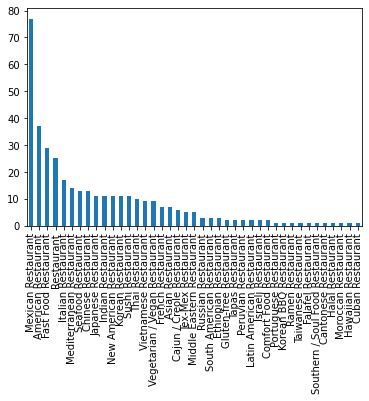

In [22]:
atxeats['Venue Category'].value_counts().plot(kind='bar')

In [23]:
atxeats['Venue Category'].value_counts(normalize=True).mul(100)

Mexican Restaurant                 20.810811
American Restaurant                10.000000
Fast Food Restaurant                7.837838
Restaurant                          6.756757
Italian Restaurant                  4.594595
Mediterranean Restaurant            3.783784
Seafood Restaurant                  3.513514
Chinese Restaurant                  3.513514
Japanese Restaurant                 2.972973
Indian Restaurant                   2.972973
New American Restaurant             2.972973
Korean Restaurant                   2.972973
Sushi Restaurant                    2.972973
Thai Restaurant                     2.702703
Vietnamese Restaurant               2.432432
Vegetarian / Vegan Restaurant       2.432432
French Restaurant                   1.891892
Asian Restaurant                    1.891892
Cajun / Creole Restaurant           1.621622
Tex-Mex Restaurant                  1.351351
Middle Eastern Restaurant           1.351351
Russian Restaurant                  0.810811
South Amer

From above it is easy to see Mexican restaurants are the most popular in Austin. From here, I decided Korean BBQ would be a great choice for a new restaurant as there are not many Korean BBQ restaurants in the area so there would not be much competition. Additionally, Texas is known for their barbecue so it would be an easy transition into a new food experience given the similarities. The novelty of cooking your own food at the dinner table is also a unique experience that could draw in big crowds.

Check how many restaurants were returned for each neighborhood

In [24]:
atxeats.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Austin1,19,19,19,19,19,19
Austin10,1,1,1,1,1,1
Austin11,17,17,17,17,17,17
Austin12,7,7,7,7,7,7
Austin15,5,5,5,5,5,5
Austin16,3,3,3,3,3,3
Austin17,5,5,5,5,5,5
Austin18,3,3,3,3,3,3
Austin19,1,1,1,1,1,1


Analyze each neighborhood

In [25]:
# one hot encoding
atx_onehot = pd.get_dummies(atxeats[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
atx_onehot['Neighborhood'] = atxeats['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [atx_onehot.columns[-1]] + list(atx_onehot.columns[:-1])
atx_onehot = atx_onehot[fixed_columns]

atx_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Ethiopian Restaurant,Falafel Restaurant,...,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
11,Austin1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Austin1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Austin1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,Austin1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,Austin1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine new dataframe size

In [26]:
atx_onehot.shape

(370, 42)

Group rows by neighborhood and mean of the frequency of occurrence of each restaurant category

In [27]:
atx_grouped = atx_onehot.groupby('Neighborhood').mean().reset_index()
atx_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Ethiopian Restaurant,Falafel Restaurant,...,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Austin1,0.210526,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.105263,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Austin10,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Austin11,0.235294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,...,0.058824,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.058824,0.000000
3,Austin12,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Austin15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.200000,0.000000,0.000000
5,Austin16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.333333,0.0000,0.000000,0.000000,0.333333,0.000000,0.000000
6,Austin17,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Austin18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.333333,0.0000,0.000000,0.000000,0.333333,0.000000,0.000000
8,Austin19,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Austin2,0.034483,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.034483,0.068966,0.000000,0.000000,0.0000,0.000000,0.034483,0.034483,0.068966,0.000000


Confirm new size

In [28]:
atx_grouped.shape

(34, 42)

Print each neighborhood with the top five most common restaurant types

In [29]:
num_top_venues = 5

for hood in atx_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = atx_grouped[atx_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Austin1----
                 venue  freq
0  American Restaurant  0.21
1           Restaurant  0.21
2   Seafood Restaurant  0.11
3   Russian Restaurant  0.05
4    Indian Restaurant  0.05


----Austin10----
                       venue  freq
0  Cajun / Creole Restaurant   1.0
1        American Restaurant   0.0
2         Seafood Restaurant   0.0
3  Middle Eastern Restaurant   0.0
4        Moroccan Restaurant   0.0


----Austin11----
                           venue  freq
0            American Restaurant  0.24
1             Mexican Restaurant  0.24
2           Fast Food Restaurant  0.12
3  Vegetarian / Vegan Restaurant  0.06
4       Mediterranean Restaurant  0.06


----Austin12----
                 venue  freq
0           Restaurant  0.43
1  American Restaurant  0.14
2   Chinese Restaurant  0.14
3  Japanese Restaurant  0.14
4   Italian Restaurant  0.14


----Austin15----
                venue  freq
0  Mexican Restaurant   0.4
1     Thai Restaurant   0.2
2  Italian Restaurant   0.2
3   

Put results into a dataframe
First, create a function to sort the venues in descending order

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create new dataframe and display top five restaurants for each neighborhood

In [31]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = atx_grouped['Neighborhood']

for ind in np.arange(atx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(atx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Austin1,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
1,Austin10,Cajun / Creole Restaurant,Vietnamese Restaurant,French Restaurant,Japanese Restaurant,Italian Restaurant
2,Austin11,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant
3,Austin12,Restaurant,American Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant
4,Austin15,Mexican Restaurant,Restaurant,Thai Restaurant,Italian Restaurant,Fast Food Restaurant


Define feature set
To use scikit-learn library we have to convert the categorical variables as binary vectors

In [32]:
atx_onehot1=atx_onehot.drop(['Neighborhood'],axis=1)
X = atx_onehot1
X[0:5]

,American Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,...,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
11,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Identify our labels

In [33]:
y = atxeats['Neighborhood'].values
y[0:5]

array(['Austin1', 'Austin1', 'Austin1', 'Austin1', 'Austin1'],
      dtype=object)

Normalize the dataset using StandardScaler() in order to interpret features with different magnitudes and distributions equally

In [34]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 3.        , -0.13886593, -0.12838815, -0.05205792, -0.19082601,
        -0.07372098, -0.05205792, -0.09041232, -0.05205792, -0.29162302,
        -0.13886593, -0.07372098, -0.05205792, -0.05205792, -0.17504476,
        -0.07372098, -0.21945077, -0.17504476, -0.05205792, -0.17504476,
        -0.07372098, -0.19830744, -0.51263889, -0.11704115, -0.05205792,
        -0.17504476, -0.07372098, -0.05205792, -0.05205792, -0.26919095,
        -0.09041232, -0.19082601, -0.09041232, -0.05205792, -0.17504476,
        -0.05205792, -0.07372098, -0.11704115, -0.16666667, -0.15789474,
        -0.15789474],
       [ 3.        , -0.13886593, -0.12838815, -0.05205792, -0.19082601,
        -0.07372098, -0.05205792, -0.09041232, -0.05205792, -0.29162302,
        -0.13886593, -0.07372098, -0.05205792, -0.05205792, -0.17504476,
        -0.07372098, -0.21945077, -0.17504476, -0.05205792, -0.17504476,
        -0.07372098, -0.19830744, -0.51263889, -0.11704115, -0.05205792,
        -0.17504476, -0.07372

Train-Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
X= preprocessing.StandardScaler().fit(X).transform(X)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (296, 41) (296,)
Test set: (74, 41) (74,)


Identify the best K value for clusters

[0.04054054 0.04054054 0.04054054 0.09459459 0.09459459 0.08108108
 0.08108108 0.09459459 0.08108108 0.08108108 0.08108108 0.06756757
 0.09459459 0.06756757]
[0.02292674 0.02292674 0.02292674 0.03402036 0.03402036 0.03173091
 0.03173091 0.03402036 0.03173091 0.03173091 0.03173091 0.02917843
 0.03402036 0.02917843]


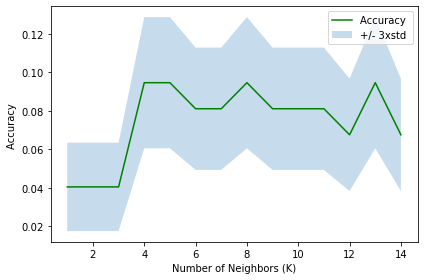

In [36]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)
print(std_acc)

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.25)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

The best K

In [37]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.0945945945945946 with k= 4


From above, we get a k of 4, which we will use to cluster the neighborhoods into 4 clusters

In [38]:
# set number of clusters
kclusters = 4

atx_grouped_clustering = atx_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(atx_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 0, 0, 3, 0])

Create new dataframe atx_merged that includes the cluster and the top 5 restaurants for each neighborhood

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

atx_merged = atxeats

# merge atx_grouped with atxeats to add latitude/longitude for each neighborhood
atx_merged = atx_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

atx_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Austin1,30.26,-97.74,Geraldine's,30.260043,-97.739126,American Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
14,Austin1,30.26,-97.74,Anthem,30.260758,-97.738108,American Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
16,Austin1,30.26,-97.74,Emmer & Rye,30.256840,-97.739380,Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
20,Austin1,30.26,-97.74,Moonshine Patio Bar & Grill,30.263827,-97.738132,American Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
21,Austin1,30.26,-97.74,G'Raj Mahal Cafe,30.258324,-97.738793,Indian Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant


Drop NA from Cluster Label column and convert to integer

In [40]:
atx_merged = atx_merged[atx_merged['Cluster Labels'].notna()]

In [41]:
atx_merged['Cluster Labels']

11      0
14      0
16      0
20      0
21      0
       ..
1880    0
1885    0
1889    0
1893    0
1894    0
Name: Cluster Labels, Length: 370, dtype: int32

In [42]:
atx_merged['Cluster Labels']=atx_merged['Cluster Labels'].astype(np.int64)

Visualize the clusters using Folium
First create a map

In [43]:
# create map
map_clusters = folium.Map(location=[latatx, longatx], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


       
map_clusters

Add markers to the map

In [44]:
near_venue = plugins.MarkerCluster().add_to(map_clusters)

for lat, lng, name, in zip(atx_merged['Venue Latitude'], atx_merged['Venue Longitude'], 
                           atx_merged['Venue Category']):
    label = folium.Popup(str(name), parse_html=True)
    folium.Marker(
        [lat, lng],
         popup=label
    ).add_to(near_venue)

markers_colors = []
for lat, lon, poi, cluster in zip(atx_merged['Neighborhood Latitude'], atx_merged['Neighborhood Longitude'], atx_merged['Neighborhood'], atx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

Examine the clusters and determine the restaurant category that distinguishes each cluster

Cluster 1: American Restaurants

In [45]:
atx_merged.loc[atx_merged['Cluster Labels'] == 0, atx_merged.columns[[1] + list(range(5, atx_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,30.26,-97.739126,American Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
14,30.26,-97.738108,American Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
16,30.26,-97.739380,Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
20,30.26,-97.738132,American Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
21,30.26,-97.738793,Indian Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,Israeli Restaurant,New American Restaurant
...,...,...,...,...,...,...,...,...,...
1880,30.27,-97.745724,Sushi Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,New American Restaurant,Cajun / Creole Restaurant
1885,30.27,-97.745779,Latin American Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,New American Restaurant,Cajun / Creole Restaurant
1889,30.27,-97.748578,Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,New American Restaurant,Cajun / Creole Restaurant
1893,30.27,-97.747960,Chinese Restaurant,0,American Restaurant,Restaurant,Seafood Restaurant,New American Restaurant,Cajun / Creole Restaurant


Cluster 2: Tex-Mex

In [46]:
atx_merged.loc[atx_merged['Cluster Labels'] == 1, atx_merged.columns[[1] + list(range(5, atx_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
983,30.19,-97.971332,Tex-Mex Restaurant,1,Tex-Mex Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Japanese Restaurant,Italian Restaurant


Cluster 3: Cajun

In [47]:
atx_merged.loc[atx_merged['Cluster Labels'] == 2, atx_merged.columns[[1] + list(range(5, atx_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
662,30.27,-97.687218,Cajun / Creole Restaurant,2,Cajun / Creole Restaurant,Vietnamese Restaurant,French Restaurant,Japanese Restaurant,Italian Restaurant


Cluster 4: Chinese

In [48]:
atx_merged.loc[atx_merged['Cluster Labels'] == 3, atx_merged.columns[[1] + list(range(5, atx_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
901,30.37,-97.841446,Chinese Restaurant,3,Chinese Restaurant,Vietnamese Restaurant,French Restaurant,Japanese Restaurant,Italian Restaurant


Locate the other Korean BBQ Restaurants in Austin

In [49]:
for lat,lng,name,venue,cluster in zip(atx_merged['Neighborhood Latitude'], atx_merged['Neighborhood Longitude'], 
                           atx_merged['Venue'], atx_merged['Venue Category'], atx_merged['Cluster Labels']):
    if venue=='Korean BBQ Restaurant':
        print('This Korean BBQ restaurant ({}) is located in cluster {} at {},{}.'.format(name,cluster,lat,lng))

This Korean BBQ restaurant (Cho Sun Gal Bi Korean BBQ & Sushi Bar) is located in cluster 0 at 30.33,-97.7.


From the result above, a restaurateur would not want to open their restaurant in cluster 0 as the only other Korean BBQ Restaurant exists in this cluster.

Visualize on the map where the other Korean BBQ Restaurant is and highlight the ideal location to open a Korean BBQ Restaurant

In [50]:
#Highlight Korean BBQ Restaurants in Area because there are so few
atxKBBQ = folium.Map(location=[latatx, longatx], zoom_start=10) # generate map centered around the Austin

near_venue = plugins.MarkerCluster().add_to(atxKBBQ)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, name, venue in zip(atx_merged['Venue Latitude'], atx_merged['Venue Longitude'], 
                           atx_merged['Venue'], atx_merged['Venue Category']):
    label = folium.Popup(str(name), parse_html=True)
    if venue == 'Korean BBQ Restaurant':
        icon_filter = folium.Icon(color='green')
        folium.Marker([lat, lng],popup=label,icon=icon_filter).add_to(near_venue)
              
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atx_merged['Neighborhood Latitude'], atx_merged['Neighborhood Longitude'], 
                                  atx_merged['Neighborhood'], atx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(atxKBBQ)

# add marker for ideal restaurant location    
    folium.Circle(
    radius=500,
    location=[30.26, -97.74],
    popup="Rainey Street",
    color="crimson",
    fill=False,
    ).add_to(atxKBBQ)
       
atxKBBQ

Austin2 (aka Rainey Street) was identified as the ideal spot to open a new Korean BBQ restaurant as it is popular and does not have any competition as no other Asian restaurants were identified to be in the area